## Wanting to test out xtrem forest and normal forest. 

In [1]:
import rasterio as rs
from matplotlib import pyplot as plt
import os
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import numpy as np 
from scipy.ndimage import generic_filter


src_folder_path = os.path.abspath('..')
project_folder_path = Path(src_folder_path).resolve().parents[0]

In [2]:
import pandas as pd
data_path = project_folder_path.joinpath(r'data\train.csv')
df = pd.read_csv(data_path)

#Split data, just to test
train_set = df.sample(frac=0.8, random_state=42) 
  
# Dropping all those indexes from the dataframe that exists in the train_set 
test_set = df.drop(train_set.index) 
train_set.shape, test_set.shape


((1688, 12), (422, 12))

Lets create more features

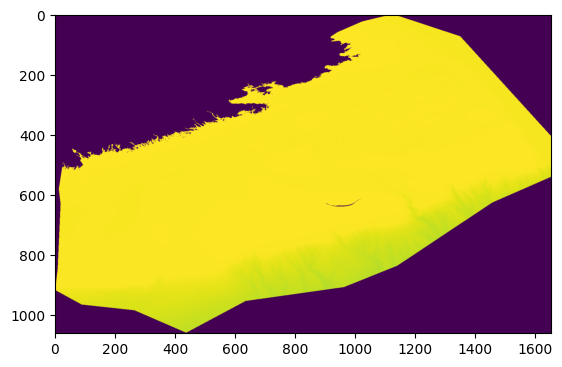

| 0.00, 0.00,-63.91|
| 0.00,-0.00, 46.59|
| 0.00, 0.00, 1.00|
0.004166666666666668
-0.004166666666666668
CRS: EPSG:4326
Units: unknown
Units: degree


In [3]:
#First, lets import the gebco

from pyproj import CRS
#degrees_to_meters = 111139
gebco = rs.open(project_folder_path.joinpath(r'data\auxiliary_data\gebco.tif'))

depth = gebco.read(1)
transform = gebco.transform
crs = gebco.crs


plt.imshow(depth)
plt.show()

print(transform)
print(transform[0])
print(transform[4])
print(f"CRS: {crs}")
units = crs.linear_units
print(f"Units: {units}") #Klarer ikke units
# Create a CRS object
crs_proj = CRS.from_wkt(crs.to_wkt())

# Get the units
units = crs_proj.axis_info[0].unit_name
print(f"Units: {units}")




In [4]:
## Slope. We need to function to calculate the size of pixels etc. 

import math
def degrees_to_meters(lat, lon, cell_size_x_deg, cell_size_y_deg):
    # Earth's radius in meters
    R = 6378137
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    
    # Calculate the size of a degree in meters at the given latitude
    meters_per_deg_lat = (2 * math.pi * R) / 360
    meters_per_deg_lon = (2 * math.pi * R * math.cos(lat_rad)) / 360
    
    # Convert cell size from degrees to meters
    cell_size_x_meters = cell_size_x_deg * meters_per_deg_lon
    cell_size_y_meters = cell_size_y_deg * meters_per_deg_lat
    
    return cell_size_x_meters, cell_size_y_meters

In [5]:
#Now we can caluclate cell size
cell_size_x, cell_size_y =  degrees_to_meters(transform[2], transform[5], transform[0],  np.abs(transform[4]))
#cell_size_x = transform[0]* degrees_to_meters
#cell_size_y = np.abs(transform[4]* degrees_to_meters)

print(f'Cell_size_x: {cell_size_x}')
print(f'Cell_size_y: {cell_size_y}')

Cell_size_x: 203.9969337425682
Cell_size_y: 463.8312116386401


In [6]:
#Lets calculate slope and aspect
# Function to calculate slope and aspect for non-square cells
def calculate_slope_aspect(dem, cell_size_x, cell_size_y):
    dzdx = (dem[:, 2:] - dem[:, :-2]) / (2 * cell_size_x)
    dzdy = (dem[2:, :] - dem[:-2, :]) / (2 * cell_size_y)
   
    grid_size_y = np.max((dzdx.shape[0],dzdy.shape[0]))
    grid_size_x = np.max((dzdx.shape[1],dzdy.shape[1]))
    #print(grid_size)
    dzdx = np.pad(dzdx, ((0, 0), (1, 1)), mode='edge')
    dzdy = np.pad(dzdy, ((1, 1), (0, 0)), mode='edge')

    slope = np.arctan(np.sqrt(dzdx**2 + dzdy**2)) * (180 / np.pi)
    aspect = np.arctan2(dzdy, -dzdx) * (180 / np.pi)
    aspect = np.where(aspect < 0, 360 + aspect, aspect)

    return slope, aspect


slope, aspect = calculate_slope_aspect(depth, cell_size_x, cell_size_y)


In [7]:
def calculate_terrain_roughness(elevation, window_size=(3,3)):
    # Open the raster file

    # Define a function to calculate the standard deviation within a window
    def roughness_std(window):
        return np.std(window)
    def roughness(window):
        return np.max(window)-np.min(window)
    # Apply the function using a moving window
    roughness_array = generic_filter(elevation, roughness, size=window_size)

   
    return roughness_array
rough = calculate_terrain_roughness(depth, window_size=(3,3))

In [8]:
def bathymetric_position_index(elevation, window_size=(3,3)):
    # Open the raster file

    # Define a function to calculate the standard deviation within a window
    def bpi_function(values):
        values = values
        center_value = values[len(values) // 2]
        neighbors_mean = np.mean(np.delete(values, len(values) // 2))
        return center_value - neighbors_mean
    # Apply the function using a moving window
    bpi= generic_filter(elevation, bpi_function, size=window_size)

   
    return bpi
bpi = bathymetric_position_index(depth, window_size=(3,3))

In [9]:
#Convert coordinates to the images coordinate:
from rasterio.transform import rowcol

# Convert coordinates to pixel positions
train_set['y_im'], train_set['x_im'] = zip(*train_set.apply(lambda x: rowcol(transform, x['x'], x['y']), axis=1))
test_set['y_im'], test_set['x_im'] = zip(*test_set.apply(lambda x: rowcol(transform, x['x'], x['y']), axis=1))

#convert x_im and y_im into meters:
test_set['x_m'], test_set['y_m'] = zip(*test_set.apply(lambda x: (x['x_im']*cell_size_x, x['y_im']*cell_size_y), axis=1))
train_set['x_m'], train_set['y_m'] = zip(*train_set.apply(lambda x: ( x['x_im']*cell_size_x, x['y_im']*cell_size_y), axis=1))

In [10]:
train_set['slope'] = train_set.apply(lambda x: slope[x['y_im'], x['x_im']], axis=1)
train_set['aspect'] = train_set.apply(lambda x: aspect[x['y_im'], x['x_im']], axis=1)

test_set['slope'] = test_set.apply(lambda x: slope[x['y_im'], x['x_im']], axis=1)
test_set['aspect'] = test_set.apply(lambda x: aspect[x['y_im'], x['x_im']], axis=1)

test_set['rough'] = test_set.apply(lambda x: rough[x['y_im'], x['x_im']], axis=1)
train_set['rough'] = train_set.apply(lambda x: rough[x['y_im'], x['x_im']], axis=1)

test_set['bpi'] = test_set.apply(lambda x: bpi[x['y_im'], x['x_im']], axis=1)
train_set['bpi'] = train_set.apply(lambda x: bpi[x['y_im'], x['x_im']], axis=1)

Skip this if not Kriging

In [11]:
kriging = 0
if kriging:


    # Lets do Kriging
    from pykrige.uk3d import UniversalKriging3D
    from pykrige.ok3d import OrdinaryKriging3D
    #data = train_set[['x_m','y_m','gebco', 'mean_gs']]
    data = train_set.sample(frac=0.5, random_state=42) 
    
    # Dropping all those indexes from the dataframe that exists in the train_set 
    #Loosing data to do kriging
    train_set_new = train_set.drop(data.index) 
    #train_set_new = train_set

    max_x,max_y = np.shape(depth)

    print(max_x)
    print(max_y)
    func = lambda x, y, z: x
else:
    train_set_new = train_set




In [12]:
if kriging:
    # Perform Ordinary Kriging in 3D
    OK3D = OrdinaryKriging3D(
        data['x_m'], data['y_m'], data['gebco'], data['mean_gs'],
        variogram_model='linear',
    )



In [13]:
if kriging:

    def find_nearest_index(array, value):
        return (np.abs(array - value)).argmin()

    interpolated_values = []
    for i in range(len(train_set_new)):
        
        interpolated_value= OK3D.execute('points', [train_set_new['x_m'].iloc[i]], [train_set_new['y_m'].iloc[i]], [[train_set_new['gebco'].iloc[i]]])[0]
        interpolated_values.append(interpolated_value)


    train_set_new['krig'] = interpolated_values




In [14]:
if kriging:
    interpolated_values = []
    for i in range(len(test_set)):
        
        interpolated_value = OK3D.execute('points', [test_set['x_m'].iloc[i]], [test_set['y_m'].iloc[i]], [[test_set['gebco'].iloc[i]]])[0]
        interpolated_values.append(interpolated_value)
    test_set['krig'] = interpolated_values

In [15]:
train_set_new.head()


,id,mean_gs,sd,skewness,kurtosis,current_max,current_mean,current_min,gebco,x,y,sample_type,y_im,x_im,x_m,y_m,slope,aspect,rough,bpi
544,629,4.49,2.61,0.82,2.47,0.103564,0.078791,0.058108,-195,-58.95333,46.25333,Grab Van Veen,81,1189,242552.354220,37570.328143,1.537367,43.063620,30,0
1986,2498,2.32,0.97,4.91,37.04,0.135892,0.095632,0.069390,-2,-63.48517,44.60333,Grab Unknown,477,101,20603.690308,221247.487952,88.378340,90.003976,-32766,8190
420,483,2.96,0.98,4.22,21.80,0.139822,0.102822,0.081560,-22,-63.38500,44.60317,Grab Van Veen,477,125,25499.616718,221247.487952,0.339245,294.453350,6,0
527,598,7.45,2.49,-0.99,2.79,1.177483,1.115310,1.021761,-1965,-61.66700,42.65167,Piston Benthos,945,537,109546.353420,438320.494999,2.803218,318.664589,47,3
196,222,1.80,0.75,4.52,40.95,0.131379,0.122668,0.118677,-22,-59.75257,43.94409,Grab Van Veen,635,997,203384.942941,294532.819391,0.460235,336.259696,7,0


In [16]:
#current range instead of max and mean
train_set_new['current_range'] = train_set_new['current_max']-train_set_new['current_min']
test_set['current_range'] = test_set['current_max']-test_set['current_min']

In [17]:
train_set_new.to_csv('train_set_new.csv', index=False)
test_set.to_csv('test_set.csv', index=False)

# Now, lets play


In [18]:
train_set_new = pd.read_csv('train_set_new.csv')
test_set = pd.read_csv('test_set.csv')
#test_set['krig'] = test_set['krig'].apply(lambda x: float(x.strip('[]')))
#train_set_new['krig'] = train_set_new['krig'].apply(lambda x: float(x.strip('[]')))


In [19]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

#train_set_new['mean_real'] =-2**(train_set_new['mean_gs'])
#test_set['mean_real'] =-2**(test_set['mean_gs'])
# Load a sample dataset (e.g., Iris dataset)

data = train_set_new
feature_columns = ['current_mean','current_range', 'gebco','x_m','y_m','slope'] #['current_mean','current_range', 'gebco', 'x_m','y_m', 'slope', 'aspect', 'krig']
target = 'mean_gs'

X = data[feature_columns]
y = data[target]






In [20]:
# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
n_estimators_range = [50, 100, 200, 500, 1000, 5000, 10000 ]

# Initialize the ExtraTreesClassifier
# Cross-validation scores
cv_scores = []
for n in n_estimators_range:
    model =  ExtraTreesRegressor(n_estimators=n, random_state=42)
    scores = cross_val_score(model, X, y, cv=5)
    cv_scores.append(np.mean(scores))


# Find the optimal number of estimators
optimal_n = n_estimators_range[np.argmax(cv_scores)]
print(f'Optimal number of estimators: {optimal_n}')

Optimal number of estimators: 10000


In [21]:
model =  ExtraTreesRegressor(n_estimators=10000, random_state=42)


# Train the model
model.fit(X, y)


ExtraTreesRegressor(n_estimators=10000, random_state=42)

In [22]:
from sklearn.metrics import r2_score
# Make predictions
X_test = test_set[feature_columns]
y_pred = model.predict(X_test)
#print(y_pred)
# Calculate the accuracy

y_test = test_set[target]


In [23]:
accuracy = r2_score(y_test, y_pred)
print(f"r2_score: {accuracy}")


r2_score: 0.2610486656013048


Bruteforce check features


In [24]:
df.head()

,id,mean_gs,sd,skewness,kurtosis,current_max,current_mean,current_min,gebco,x,y,sample_type
0,1,2.48,1.33,3.70,24.33,0.164273,0.156398,0.146120,-227,-60.09194,43.57372,Grab Van Veen
1,2,4.15,1.82,2.34,9.43,0.116663,0.101989,0.092233,-17,-60.05735,43.91429,Grab Video
2,3,1.79,0.98,4.16,26.64,0.116663,0.101989,0.092233,-17,-60.05735,43.91429,Grab Video
3,4,1.58,0.75,5.16,45.76,0.106330,0.091203,0.081784,-18,-60.09058,43.91506,Grab Video
4,5,0.85,1.16,1.04,15.00,0.106330,0.091203,0.081784,-18,-60.08782,43.91469,Grab Video


In [25]:
import itertools


# Assuming df is your pandas dataframe with the features and target variable
df = pd.read_csv('train_set_new.csv') # Load your dataframe here
target = 'mean_gs'

# Separate features and target variable
X = df.drop(columns=target)
X = X.drop(columns=['id', 'sd', 'skewness', 'kurtosis', 'sample_type'])
y = df[target]

# List of different estimators to test
estimators = [10, 50, 100, 200,10000]

# Dictionary to store results
results = {}

# Iterate over all combinations of features
for L in range(1, len(X.columns) + 1):
    for subset in itertools.combinations(X.columns, L):
        subset = list(subset)
        X_subset = X[subset]
        
        for n_estimators in estimators:
            model = ExtraTreesRegressor(n_estimators=n_estimators, random_state=42)
            scores = cross_val_score(model, X_subset, y, cv=5)
            mean_score = np.mean(scores)
            
            # Store the result
            results[(tuple(subset), n_estimators)] = mean_score

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(results.items(), columns=['params', 'score'])
results_df['features'] = results_df['params'].apply(lambda x: ', '.join(x[0]))
results_df['n_estimators'] = results_df['params'].apply(lambda x: x[1])



KeyboardInterrupt: 

In [26]:
results_df = pd.DataFrame(results.items(), columns=['params', 'score'])
results_df['features'] = results_df['params'].apply(lambda x: ', '.join(x[0]))
results_df['n_estimators'] = results_df['params'].apply(lambda x: x[1])

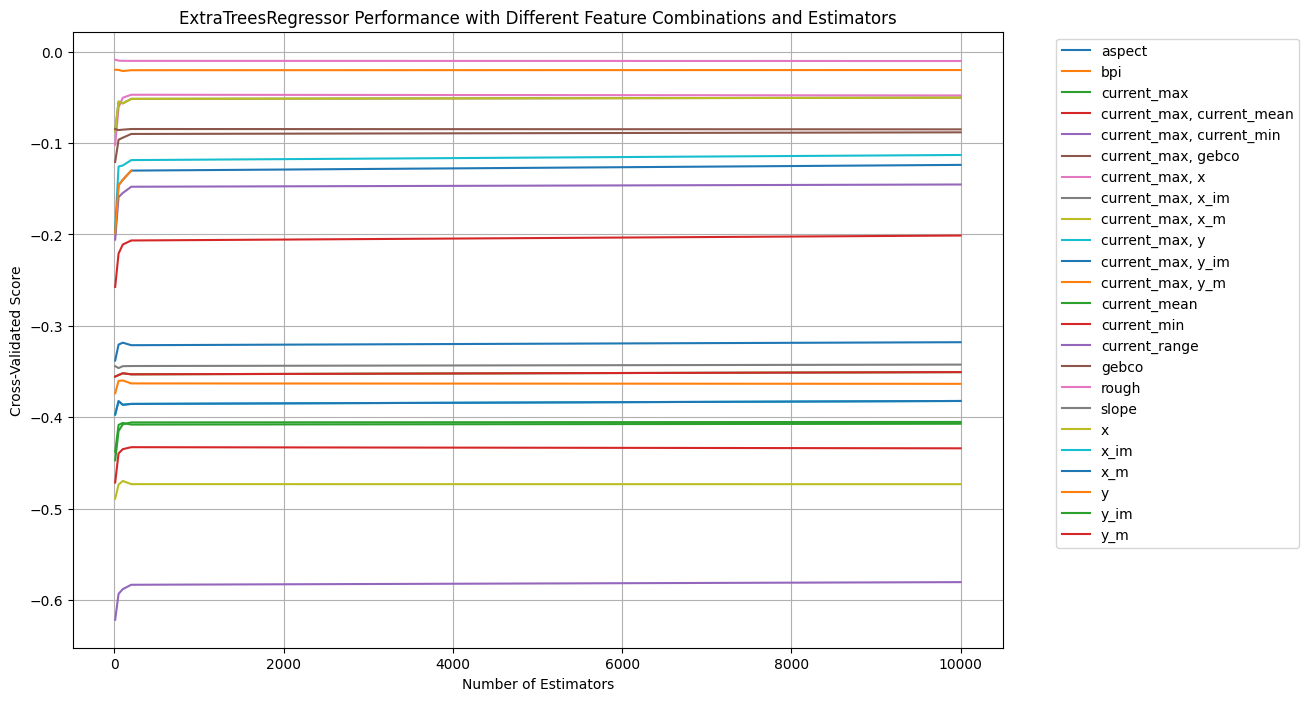

In [27]:
# Plot the results
plt.figure(figsize=(12, 8))
for key, grp in results_df.groupby(['features']):
    plt.plot(grp['n_estimators'], grp['score'], label=key)

plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated Score')
plt.title('ExtraTreesRegressor Performance with Different Feature Combinations and Estimators')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()